In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import remove_outliers

# 2.0 EDA

## Data preparation/cleaning

In [2]:
df = pd.read_csv('../lab/data/cardio_train.csv', index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [4]:
# age recalculated from days to years
df['age'] = df['age']/365

In [5]:
# change ome col names
df = df.rename(columns={'ap_hi': 'systolic_high', 'ap_lo': 'diastolic_low', 'gluc': 'glucose', 'alco': 'alcohol', 'cardio': 'cardio_disease'})

In [6]:
# check values in columns containing cathegorical values
df["gender"].value_counts(), df["cholesterol"].value_counts(), df[
    "glucose"
].value_counts(), df["smoke"].value_counts(), df["alcohol"].value_counts(), df[
    "active"
].value_counts(), df[
    "cardio_disease"
].value_counts()

#-----------------------------------------------------------------------------------
# all seem ok

(1    45530
 2    24470
 Name: gender, dtype: int64,
 1    52385
 2     9549
 3     8066
 Name: cholesterol, dtype: int64,
 1    59479
 3     5331
 2     5190
 Name: glucose, dtype: int64,
 0    63831
 1     6169
 Name: smoke, dtype: int64,
 0    66236
 1     3764
 Name: alcohol, dtype: int64,
 1    56261
 0    13739
 Name: active, dtype: int64,
 0    35021
 1    34979
 Name: cardio_disease, dtype: int64)

In [7]:
# check reasonalbility of columns containing non-cathegorical values
df.describe()

#-----------------------------------------------------------------------------------------
# age - reasonable
# hight - very low and very high values present (most humans can be assumed to be between 145-200 cm)
# weight - too low values present (consideing min age is 26 years, reasonable with margins 30 and above)
# systolic_high - too low and too high values present (reasonable with margins between 50 - 250)
# diastolic_low - too low and too high values present (reasonable with margins between 20 - 180)

,age,gender,height,weight,systolic_high,diastolic_low,cholesterol,glucose,smoke,alcohol,active,cardio_disease
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339358,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.759594,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.583562,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.394521,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980822,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430137,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


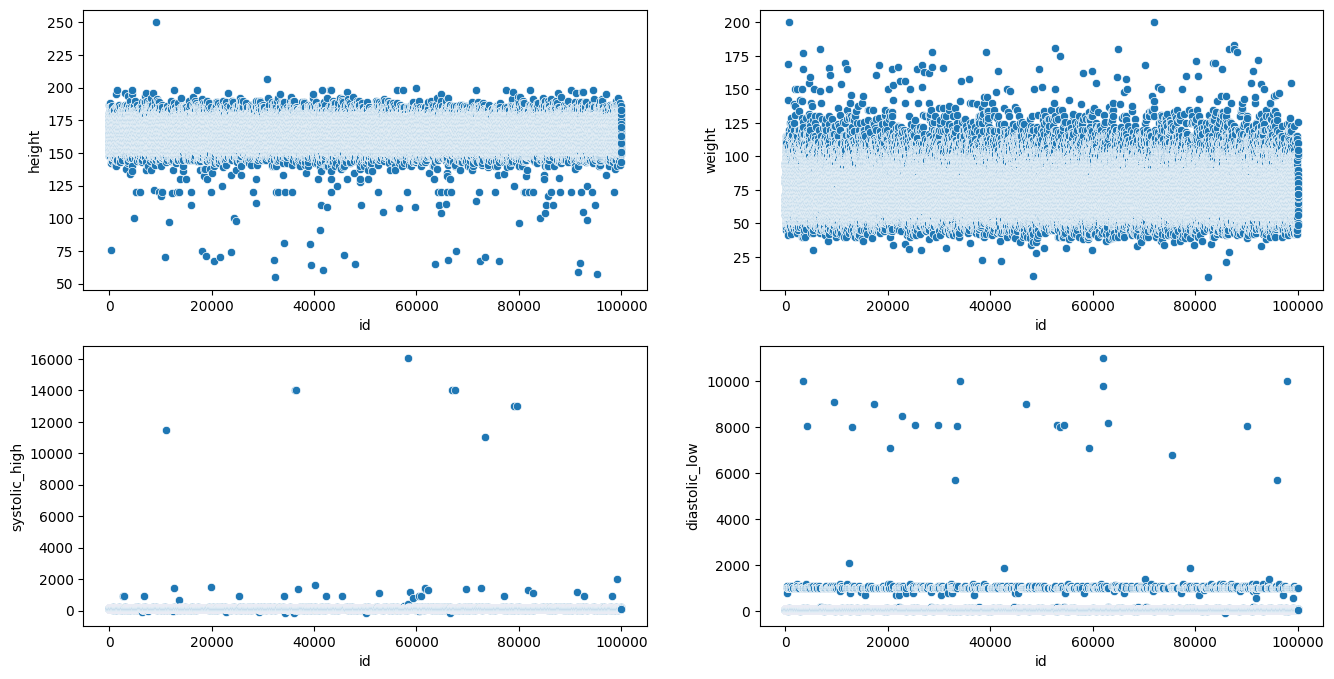

In [8]:
# visualizing all data
fig, axes = plt.subplots(2,2, figsize = (16,8))
y_cols = ['height', 'weight', 'systolic_high', 'diastolic_low']

# axes.faltten creates a list-like object ([axes[0][0], axes[0][1], axes[1][0], axes[1][1]], ....)
for ax, y_col in zip(axes.flatten(), y_cols):
    sns.scatterplot(data=df, x=df.index, y= y_col, ax = ax)

Height:
* values below 100 are suspected to be typos where 100-s was missed. can not be sure, thus remove those datapoints
* most humas should be between 145-200 cm thus remove datapoints which are not between 125-220 cm

Weight:
* values below 30 are removed

Systolic_high:
* keep values 50-250

Diastolic_low
* keep values 20-180

In [9]:
# removing rows with datapoints which are not physically feasable
df = df.query(
    "height >= 125 & height <= 220 & weight >= 30 & systolic_high <= 250 & systolic_high >= 50 & diastolic_low <= 180 & diastolic_low >= 20"
)

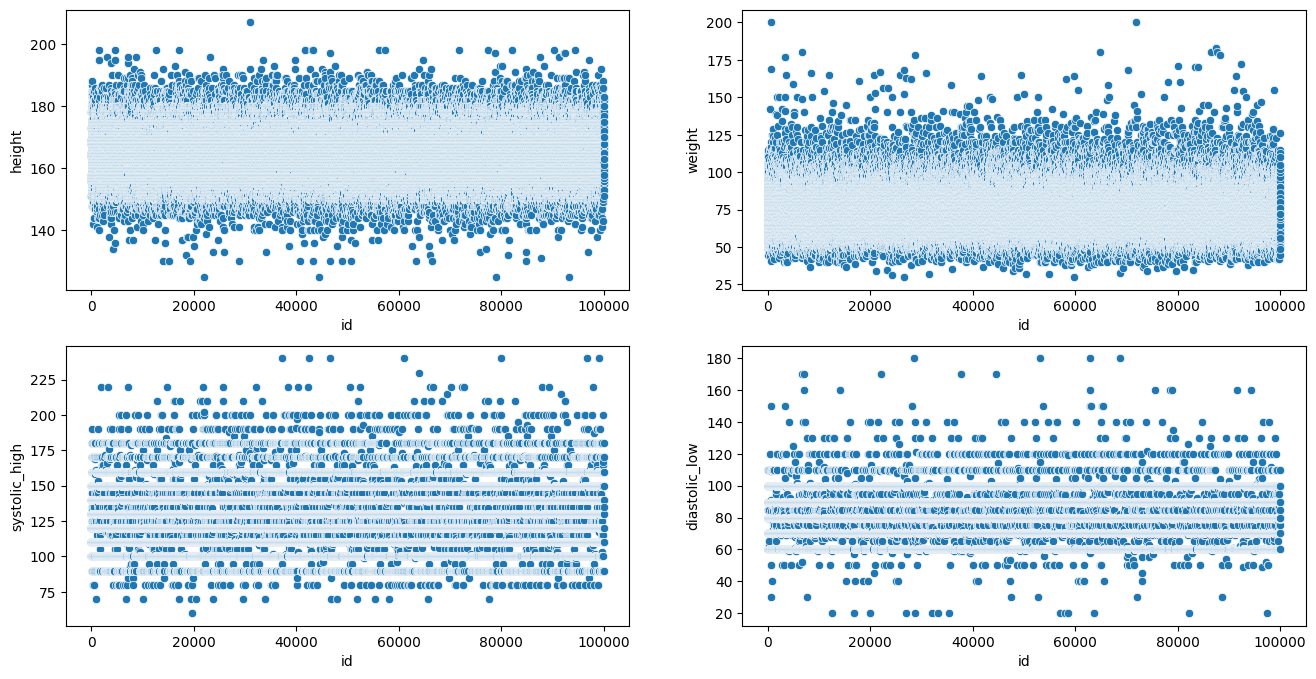

In [10]:
# visualizing cleaned data

fig, axes = plt.subplots(2,2, figsize = (16,8))
y_cols = ['height', 'weight', 'systolic_high', 'diastolic_low']

for ax, y_col in zip(axes.flatten(), y_cols):
    sns.scatterplot(data=df, x=df.index, y= y_col, ax = ax)

In [11]:
df.info()

#-------------------------------------
# while cleaning data 1298 points were removed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68702 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             68702 non-null  float64
 1   gender          68702 non-null  int64  
 2   height          68702 non-null  int64  
 3   weight          68702 non-null  float64
 4   systolic_high   68702 non-null  int64  
 5   diastolic_low   68702 non-null  int64  
 6   cholesterol     68702 non-null  int64  
 7   glucose         68702 non-null  int64  
 8   smoke           68702 non-null  int64  
 9   alcohol         68702 non-null  int64  
 10  active          68702 non-null  int64  
 11  cardio_disease  68702 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.8 MB


### a) How many are positive and how many are negative for cardio-vascular disease?
34699 negative, 34003 positive

In [12]:
df['cardio_disease'].value_counts()

0    34699
1    34003
Name: cardio_disease, dtype: int64

### b). What are fractions of people with 1: normal, 2: above normal, 3: well above normal cholesterol?

In [13]:
df['cholesterol'].value_counts()

1    51518
2     9306
3     7878
Name: cholesterol, dtype: int64

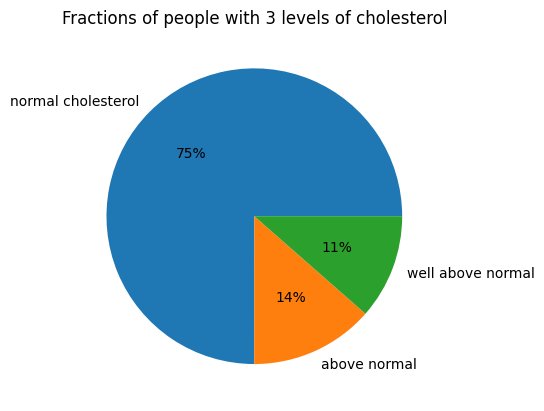

In [14]:
plt.pie(df['cholesterol'].value_counts(), autopct='%.0f%%', labels=['normal cholesterol', 'above normal', 'well above normal']);
plt.title('Fractions of people with 3 levels of cholesterol');

### c) Plot histogram over age distribution

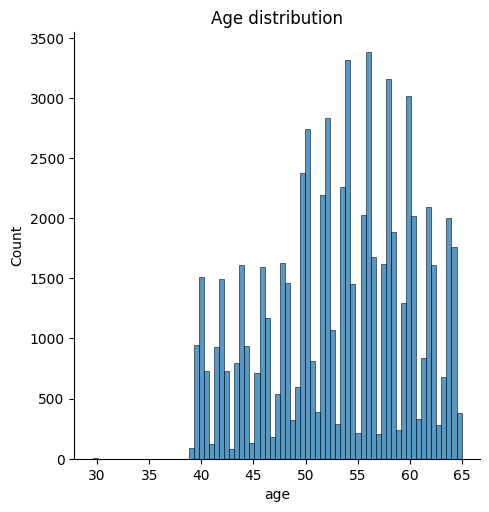

In [15]:
sns.displot(df, x='age').set(title = 'Age distribution');

### d) What percentage smokes?
8.8 % smoke

In [16]:
100 * (df['smoke'].sum()/len(df))

8.800326045821084

### e) Plot weight distribution

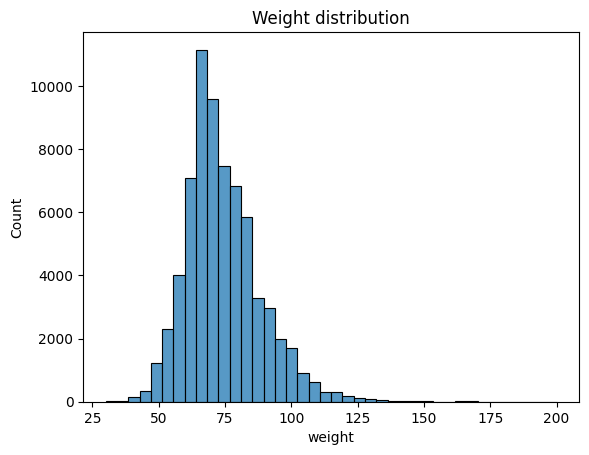

In [17]:
sns.histplot(df, x='weight', bins=40).set(title = 'Weight distribution');

### f) Plot height distribution

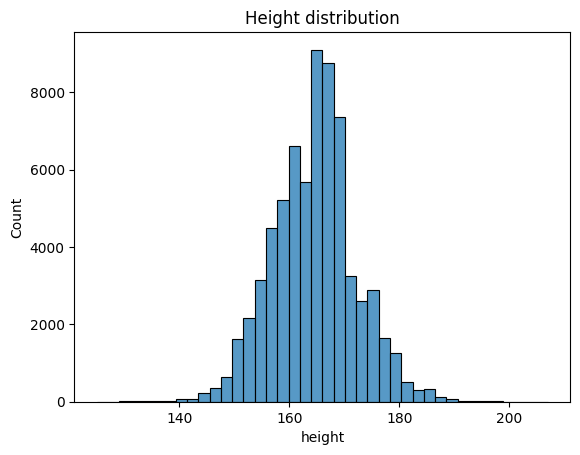

In [18]:
sns.histplot(df, x='height', bins=40).set(title = 'Height distribution');

### g) What percentage of women and men have cardiovascular desease?
49 % of women, 50 % of men

In [19]:
percentage_women = 100 * len(df.query('gender == 1 & cardio_disease == 1'))/len(df.query('gender == 1'))
percentage_women

49.226711961380296

In [20]:
percentage_men = 100 * len(df.query('gender == 2 & cardio_disease == 1'))/len(df.query('gender == 2'))
percentage_men

49.99165205776776

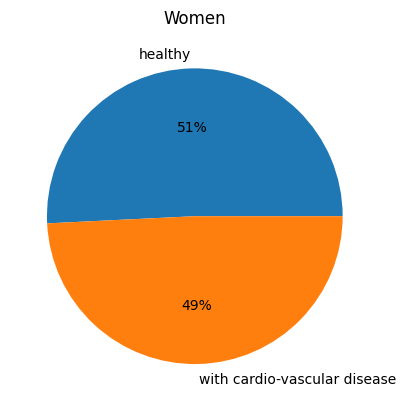

In [21]:
df_women = df[df['gender'] == 1]
plt.pie(df_women['cardio_disease'].value_counts(), autopct='%.0f%%', labels=['healthy', 'with cardio-vascular disease']);
plt.title('Women');


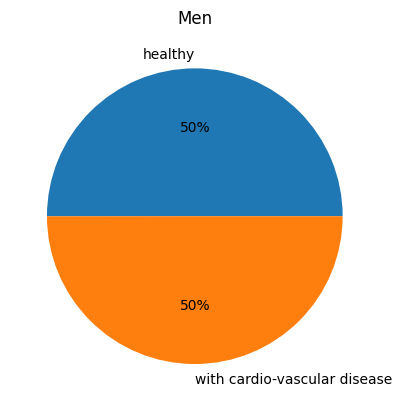

In [22]:
df_men = df[df['gender'] == 2]
plt.pie(df_men['cardio_disease'].value_counts(), autopct='%.0f%%', labels=['healthy', 'with cardio-vascular disease']);
plt.title('Men');

# 2.1.0 Feature engineering BMI

### Create BMI feature

In [23]:
df['BMI'] = df['weight']/(0.0001 * df['height'] * df['height'])
df.head()

,age,gender,height,weight,systolic_high,diastolic_low,cholesterol,glucose,smoke,alcohol,active,cardio_disease,BMI
id,,,,,,,,,,,,,
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


### a) Clean BMI column from outliers and not reasonable values
Min and max thresholds for BMI according to theory are < 16.0 and >= 40, thus BMI in our data far from these can probably be considered ouliers. For a more stringent approach Tukeys rule can be used, where outliers can be visulaized with boxplot. In our data removing ouliers accoring to Tukeys rule results in BMI_min = 14.5 and BMI_max = 39.5, which is in the same range as theoretical cut-offs.

Text(0.5, 0.98, 'BMI in dataset prior to removal of ouliers')

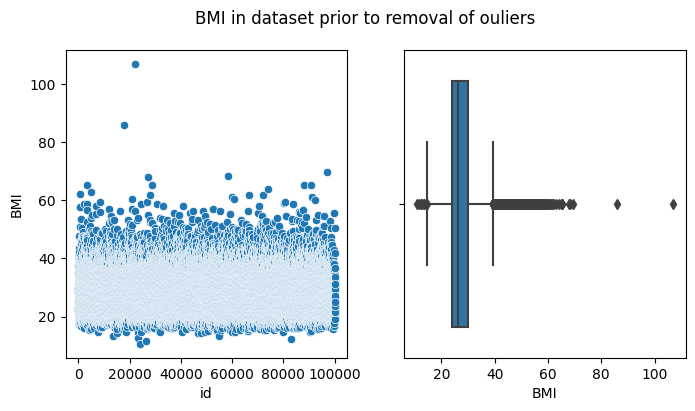

In [24]:
# scatterplott and corresponding boxplot of all BMI i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'BMI', ax=ax[0]);
sns.boxplot(data=df, x="BMI", ax=ax[1]);
fig.suptitle('BMI in dataset prior to removal of ouliers')

In [25]:
df = remove_outliers(df, 'BMI')

In [26]:
df['BMI'].min(), df['BMI'].max()

(14.524328249818446, 39.47681331747919)

Text(0.5, 0.98, 'BMI in dataset after removal of ouliers')

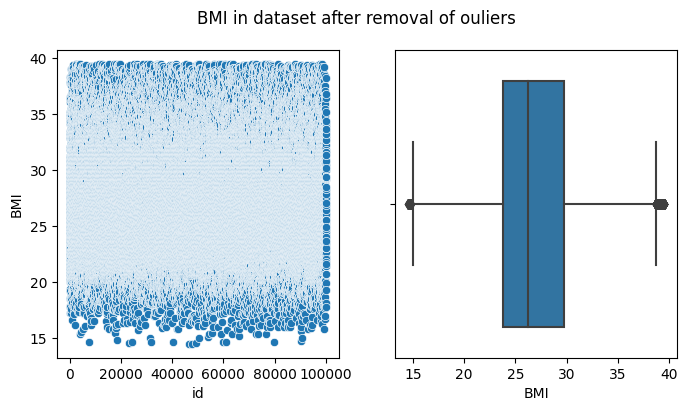

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'BMI', ax=ax[0]);
sns.boxplot(data=df, x="BMI", ax=ax[1]);
fig.suptitle('BMI in dataset after removal of ouliers')

### b) Create a categorical BMI feature
|Category          |threshold      | index |
|-------------------|---------------|-------|
|Underweight (Thin) |	< 18.5      |0      |
|Normal range    	|18.5 – 24.9    |1      |
|Overweight     	|25.0 – 29.9    |2      |
|Obesity (Class 1)	|30.0 – 34.9    |3      |
|Obesity (Class 2)	|35.0 – 39.9    |4      |
| Obesity (Class 3)	|≥ 40.0         |5      |

In [28]:
def categorize_BMI(BMI):
    if BMI < 25:
        return 1
    if BMI >= 25 and BMI < 30:
        return 2
    if BMI >= 30 and BMI < 35:
        return 3
    if BMI >= 35 and BMI < 40:
        return 4
    if BMI >= 40:
        return 5

In [29]:
df['BMI_category'] = df['BMI'].apply(categorize_BMI)
df.head()

,age,gender,height,weight,systolic_high,diastolic_low,cholesterol,glucose,smoke,alcohol,active,cardio_disease,BMI,BMI_category
id,,,,,,,,,,,,,,
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,1
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,3
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,2
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,1


# 2.1.1 Feature engineering blood pressure

### Systolic pressure - removing outliers
Min and max thresholds for systolic blood pressure according to referenced article are < 120 mmHg and > 180 mmHg. After removing outliers using Tukeys rule systolic bloodpressure values in dataset were between 93 - 169 mmHg, which is reasonably close to min/max thresholds. Possibly some points at high end should not have been removed.

Text(0.5, 0.98, 'Systolic pressure in dataset prior to removal of ouliers')

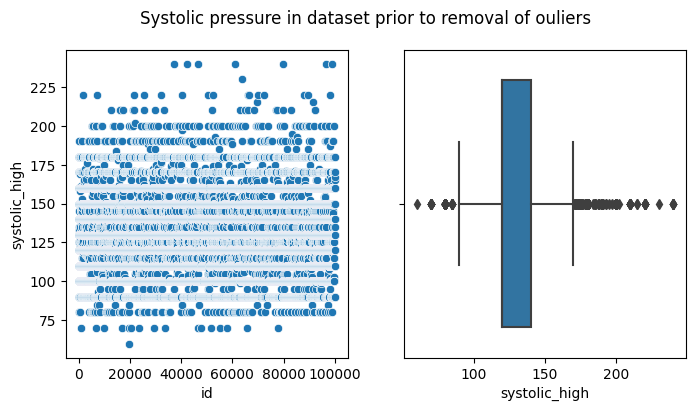

In [30]:
# scatterplott and corresponding boxplot of all systolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'systolic_high', ax=ax[0]);
sns.boxplot(data=df, x="systolic_high", ax=ax[1]);
fig.suptitle('Systolic pressure in dataset prior to removal of ouliers')

In [31]:
df = remove_outliers(df, 'systolic_high')

In [32]:
df['systolic_high'].min(), df['systolic_high'].max()

(93, 169)

Text(0.5, 0.98, 'Systolic pressure in dataset after removal of ouliers')

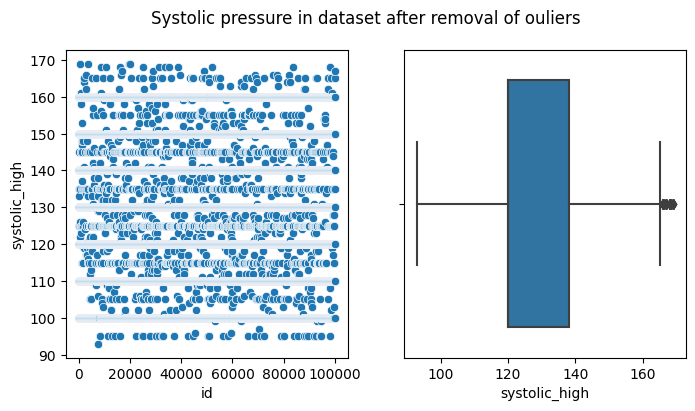

In [33]:
# scatterplott and corresponding boxplot of all systolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'systolic_high', ax=ax[0]);
sns.boxplot(data=df, x="systolic_high", ax=ax[1]);
fig.suptitle('Systolic pressure in dataset after removal of ouliers')

### Diastolic pressure - removing outliers
Min and max thresholds for diastolic blood pressure according to referenced article are < 80 mmHg and > 120 mmHg. After removing outliers using Tukeys rule diastolic bloodpressure values in dataset were between 66 - 104 mmHg, which is reasonably close to min/max thresholds. Possibly some points at high end should not have been removed.

Text(0.5, 0.98, 'Diastolic pressure in dataset prior to removal of ouliers')

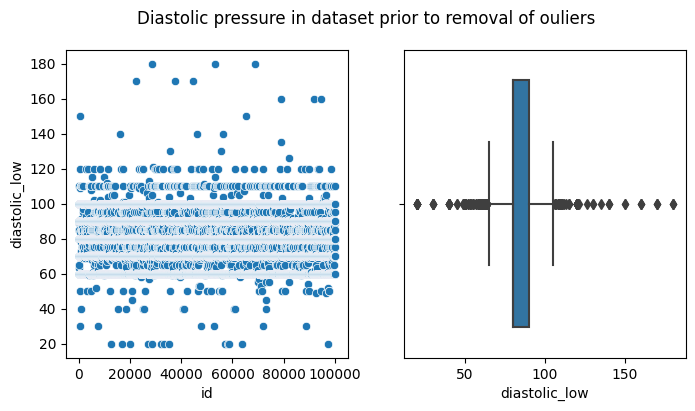

In [34]:
# scatterplott and corresponding boxplot of all diastolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'diastolic_low', ax=ax[0]);
sns.boxplot(data=df, x="diastolic_low", ax=ax[1]);
fig.suptitle('Diastolic pressure in dataset prior to removal of ouliers')

In [35]:
df = remove_outliers(df, 'diastolic_low')

In [36]:
df['diastolic_low'].min(), df['diastolic_low'].max()

(66, 104)

Text(0.5, 0.98, 'Diastolic pressure in dataset after removal of ouliers')

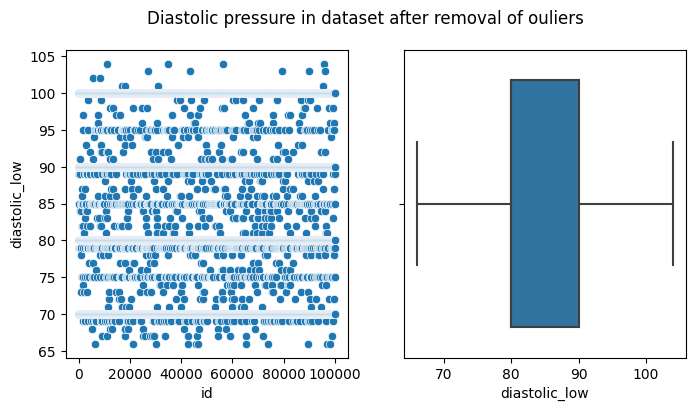

In [37]:
# scatterplott and corresponding boxplot of all diastolic pressure i dataset

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(data=df, x=df.index, y= 'diastolic_low', ax=ax[0]);
sns.boxplot(data=df, x="diastolic_low", ax=ax[1]);
fig.suptitle('Diastolic pressure in dataset after removal of ouliers')

Final dataset after outlier removal contains 61910 samples out of the original 70000.

### Create a categorical blood pressure feature

|Category               | index  |
|-------------------    |------- |
|Healthy                |1       |
|Elevated          	    |2       |
|Stage 1 hypertension   |3       |
|Stage 2 hypertension	|4       |


thresholds according to table https://www.healthline.com/health/high-blood-pressure-hypertension#symptoms

In [38]:
def categorize_blood_pressure(systolic, diastolic):
    """Categorizes blood pressure 1-4 depending on systolic and diastolic pressures"""
    if  systolic < 120 and diastolic < 80:
        return 1
    if  systolic >= 120 and systolic <130 and diastolic < 80:
        return 2
    if  systolic >= 130 and systolic <140 or diastolic >= 80 and diastolic < 90:
        return 3
    if  systolic >= 140 or diastolic >= 90:
        return 4

In [39]:
new_col = df.apply(lambda row: categorize_blood_pressure(row['systolic_high'], row['diastolic_low']), axis = 1)
df.insert(loc = 6, column='blood_pressure_category', value=new_col)

In [40]:
df.head()

,age,gender,height,weight,systolic_high,diastolic_low,blood_pressure_category,cholesterol,glucose,smoke,alcohol,active,cardio_disease,BMI,BMI_category
id,,,,,,,,,,,,,,,
0,50.391781,2,168,62.0,110,80,3,1,1,0,0,1,0,21.967120,1
1,55.419178,1,156,85.0,140,90,4,3,1,0,0,1,1,34.927679,3
2,51.663014,1,165,64.0,130,70,3,3,1,0,0,0,1,23.507805,1
3,48.282192,2,169,82.0,150,100,4,1,1,0,0,1,1,28.710479,2
8,60.038356,1,151,67.0,120,80,3,2,2,0,0,0,0,29.384676,2


# 2.2.0 Visualisation - percentage disease

# 2.2.1 Visualisation - correlation
Strong correlation can be seen between BMI - BMI_category - weight, all of each are dependant on eachother <br>
Strong correlation can also be seen between systolic - diastolic - blood pressure category <br>
There is a correlation between systolic and diastolic blood pressures <br>
Onset of disease seems to be moslty correlated to systolic blood pressure followed by diastolic blood pressure, age, BMI. However all of which are weak.

<Axes: >

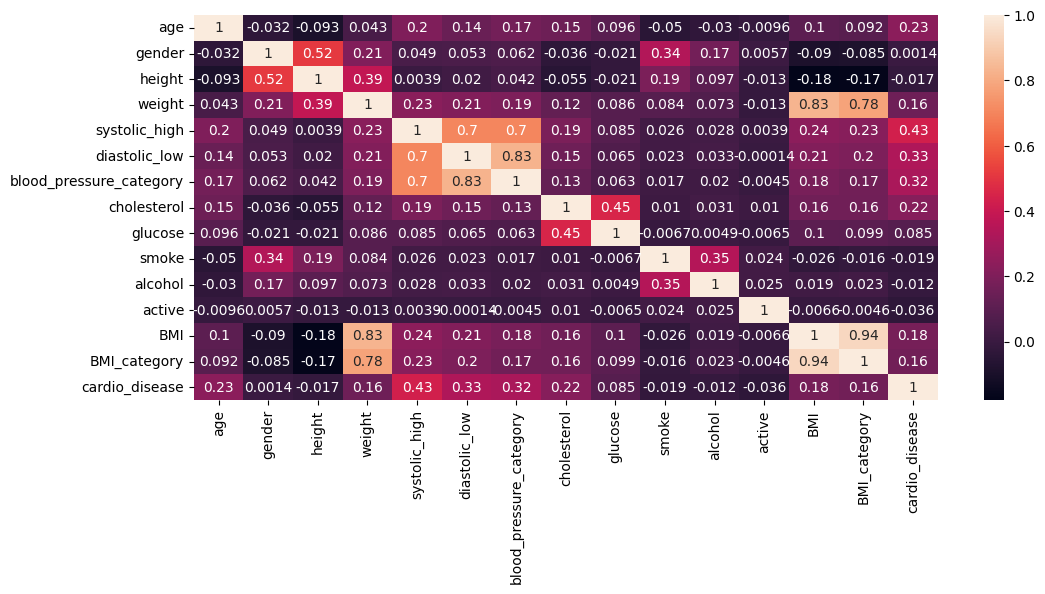

In [76]:
fig = plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True)

# 2.3 Create 2 datasets

In [70]:
df_1 = df.drop(columns=['systolic_high', 'diastolic_low', 'height', 'weight', 'BMI'])
df_1 = pd.get_dummies(data=df_1, columns=['BMI_category', 'blood_pressure_category', 'gender'], drop_first=True)
df_1.head(3)

,age,cholesterol,glucose,smoke,alcohol,active,cardio_disease,BMI_category_2,BMI_category_3,BMI_category_4,blood_pressure_category_2,blood_pressure_category_3,blood_pressure_category_4,gender_2
id,,,,,,,,,,,,,,
0,50.391781,1,1,0,0,1,0,0,0,0,0,1,0,1
1,55.419178,3,1,0,0,1,1,0,1,0,0,0,1,0
2,51.663014,3,1,0,0,0,1,0,0,0,0,1,0,0


In [71]:
df_2 = df.drop(columns=['BMI_category', 'blood_pressure_category', 'height', 'weight'])
df_2 = pd.get_dummies(data=df_2, columns=['gender'], drop_first= True)
df_2.head(3)

,age,systolic_high,diastolic_low,cholesterol,glucose,smoke,alcohol,active,BMI,cardio_disease,gender_2
id,,,,,,,,,,,
0,50.391781,110,80,1,1,0,0,1,21.967120,0,1
1,55.419178,140,90,3,1,0,0,1,34.927679,1,0
2,51.663014,130,70,3,1,0,0,0,23.507805,1,0


# Choose model